In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from IPython.display import display, Math, Latex, HTML
from mpl_toolkits.mplot3d.axes3d import Axes3D
from ipywidgets import interact, IntSlider, interactive
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Title
from bokeh.io import push_notebook, show, output_notebook

import warnings
warnings.filterwarnings('ignore')
from bokeh.layouts import gridplot, row
output_notebook()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(0)
tf.set_random_seed(0)

Loading BokehJS ...

## Data

In [2]:
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_samples = mnist.train.num_examples
print ('number of sumples:', n_samples)

number of sumples: 55000


## some model utils

In [4]:
# feed_forward model structure
from keras.layers import Input, Dense
from keras.models import Sequential, Model

def feed_forward(input_dim, layers):
    """
    Return a keras model object.
    input_dim: the orginial input dims
    layers: a list specifying the dims of each layer
    """
    model = Sequential()
    for i in range(len(layers)):
        if i == 0:
            model.add(Dense(layers[i], input_shape=(input_dim,), activation='relu'))
        else:
            model.add(Dense(layers[i], activation='relu'))
    return model

Using TensorFlow backend.


## VAE

In [5]:
class VA(object):
    def __init__(self, batch_size, input_dim, latent_dim, lr):
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lr = lr
        self._initialize()

    def _initialize(self):
        # placeholder for input data
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        # create network
        self.create_network()
        self.loss()
        # init tensorflow graph
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def encoder_network(self, x):
        """
        Takes in x, and return parameters of latents z.
        """
        # two intermediate layer
        layers = [32, 32]
        h = feed_forward(self.input_dim, layers)(x)
        z_mean = Dense(self.latent_dim)(h)
        z_log_var = Dense(self.latent_dim)(h)
        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        """
        Takes in the parameters for z, and return samples.
        """
        epsilon = tf.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                   stddev=1.0)
        z = z_mean + tf.exp(z_log_var / 2) * epsilon
        return z

    def decoder_network(self, z):
        """
        Take latents, and return reconstruction.
        """
        layers = [32, 32]
        h = feed_forward(self.latent_dim, layers)(z)
        x_recon_mean = Dense(self.input_dim, activation='sigmoid')(h)
        return x_recon_mean

    def create_network(self):
        self.z_mean, self.z_log_var = self.encoder_network(self.x)
        self.z = self.sampling(self.z_mean, self.z_log_var)
        self.x_decoded = self.decoder_network(self.z)

    def loss(self):
        kl_loss = -0.5 * tf.reduce_sum(1 + self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var), axis=1)
        xent_loss = -tf.reduce_sum(
            self.x * tf.log(1e-9 + self.x_decoded) + (1 - self.x) * tf.log(1e-9 + 1 - self.x_decoded), 1)
        self.cost = tf.reduce_mean(kl_loss + xent_loss)
        self.opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.cost)

    def minbatch_fit(self, X):
        opt, cost = self.sess.run((self.opt, self.cost), feed_dict={self.x: X})
        return cost

    def latent_space_visulization(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def recons(self, X):
        return self.sess.run(self.x_decoded, feed_dict={self.x: X})

    def generating_samples(self, z_mu):
        return self.sess.run(self.x_decoded, feed_dict={self.z: z_mu})


In [6]:
batch_size=100
input_dim = 784
latent_dim = 2
lr = 0.001

va = VA(batch_size, input_dim, latent_dim, lr)

## Training

In [7]:
training_epochs=5
printing = 1

In [8]:
x_sample_m, y_labels_m = mnist.test.next_batch(3000)
cost_plotting=[]
laten_space=[]
reconstructed=[]
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        cost = va.minbatch_fit(batch_xs)
        avg_cost += cost / n_samples * batch_size
        
    if epoch % printing == 0:
        cost_plotting.append(avg_cost)
        laten_space.append(va.latent_space_visulization(x_sample_m))
        reconstructed.append(va.recons(x_sample_m[:100]))
        print("Ittiration:", '%02d' % (epoch+1), "Average_cost=", "{:.9f}".format(avg_cost))

Ittiration: 01 Average_cost= 221.066943110
Ittiration: 02 Average_cost= 183.450483842
Ittiration: 03 Average_cost= 174.573044600
Ittiration: 04 Average_cost= 169.242718783
Ittiration: 05 Average_cost= 166.597397211


In [9]:
class Visualization(object):
    def __init__(self, total_epoch, batch_size, printing):
        #This is the visualazation library used for this notebook
        self.total_epoch=total_epoch
        self.batch_size=batch_size
        self.printing=printing
    
    def plotting_cost(self, cost_list):
        '''
        Function plots cost
        
        Paramaters:
        __________
        
        cost_list: list of error cost/loss during the training
        
    
        '''
        
        fig, axes = plt.subplots(figsize=(4, 5), dpi=100)
        axes.plot(np.arange(len(cost_list))*self.printing, cost_list, color='red', lw=2, alpha=0.4)
        axes.scatter(np.arange(len(cost_list))*self.printing, cost_list, color='black', alpha=0.9)
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Cost')
        axes.grid(alpha=0.09, color='grey')
        plt.tight_layout()
        
    def plotting_latent_space(self, z_space, y_labels):
        
        '''
        Function plots changes in Z space during the training 
        
        Paramaters:
        __________
        
        z_space: list contaning numpy array over training, Dimensions [training epochs x  2D].
                 Z_space must be 2-dimensiol, if Z-space is 3D or hight, transfrom it to 2D via PCA or 
                 tSNE
        
        y_labels: labels for data that was passed via Z space, labels must be binary matrix 
                  [number_samples x  number of total class] 
        
    
        '''
        #color_dictionary
        self.z_space=z_space
        self.y_labels=y_labels
        self.c_dict={0: 'blue', 
                1: 'pink', 
                2: 'green',
                4: "red",
                5: "olive", 
                6: "darkred", 
                7: "grey", 
                8: "skyblue", 
                9: "orange"}

        #listt of colors per position
        self.k=list(map(self.c_dict.get, list(np.argmax(y_labels, axis=1))))
        
        #data_column for feeding and updating in to the graph
        source = ColumnDataSource(dict(
            x=self.z_space[0][:, 1],
            y=self.z_space[0][:, 0],
            color=self.k, 
            labels=np.argmax(self.y_labels, axis=1),
            line_color=self.k
        ))
        p = figure(plot_width=650, 
                   plot_height=650, 
                   x_range=(-6.5, 6.5), 
                   y_range=(-6.5, 6.5), 
                   logo=None)
        
        p.circle(x='x',
                 y='y', 
                 size=10, 
                 line_color='line_color', 
                 legend='labels', 
                 color='color',
                 alpha=0.4, 
                 source=source)
        
        p.xgrid.grid_line_color = None
        p.ygrid.grid_line_color = None
        p.toolbar_location = None
        p.xaxis.minor_tick_line_color = None
        p.xgrid.grid_line_color = 'grey'
        p.xgrid.grid_line_alpha = 0.1
        p.xaxis.bounds = (-6.5, 6.5)
        p.yaxis.major_tick_line_width = 3
        p.yaxis.minor_tick_line_color = None
        p.ygrid.grid_line_color = 'grey'
        p.ygrid.grid_line_alpha = 0.1
        p.yaxis.bounds = (-6.5, 6.5)
        p.yaxis.major_tick_line_width = 3
        p.legend.location = "top_right"
        p.legend.orientation = "vertical"
        
        show(p, notebook_handle=True)
        
        def update(g):
            w=g
            new_data = dict(x=self.z_space[w][:, 0], 
                            y=self.z_space[w][:, 1],
                            color=self.k, 
                            labels=np.argmax(self.y_labels, axis=1), 
                            line_color=self.k)
            source.data = new_data
            p.title.text = str(' number of epoch: ' + str(w))
            push_notebook()


        slider = IntSlider(min=0, max=(self.total_epoch//self.printing)-1, step=1, description='Epoch')
        interact(update,  g=slider);
        
    def plotting_training_visual(self, reconstruction, true_x):
        '''
        Function accepts true x datasate, and uses NN netwrok to reconstruct its images over 
        the tranings, size of true_x and reconstruction matrices should be 
        [batch_size x vectrized image]
        
        Paramaters:
        __________
        
        reconstruction: result of true_data passed via neural netwrok
        
        true_x: data that was passed for generating reconstruction, must be flatten image
        
        '''
        
        x_reshaped=np.array(reconstructed).reshape(self.total_epoch//self.printing, self.batch_size, 28, 28)
        x_true=true_x[:self.batch_size].reshape(self.batch_size, 28, 28)
        
        custum_blue=['#ffffff','#f0f0f0','#d9d9d9', '#a6bddb','#74a9cf','#3690c0','#0570b0','#045a8d','#023858']
        custum_grey=['#ffffff','#f0f0f0','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525', '#000000']

        r1, r2, r3, r4=np.random.randint(0, batch_size, 4)
        figure_settings={'toolbar_location': None, 
              'plot_width': 230,
              'plot_height': 230,
              'x_range': (0, 28), 
              'y_range': (0, 28),
              'logo': None}

        image_settings_target={'x': 0, 
                        'y': 0, 
                        'dw': 28,
                        'dh': 28,
                        'palette': custum_grey}

        image_settings_recons={'x': 0, 
                        'y': 0, 
                        'dw': 28,
                        'dh': 28,
                        'palette': custum_blue}

        p1 = figure(**figure_settings)
        p1.image(image=[x_reshaped[0][r1]], **image_settings_recons)
        p1.axis.visible=False
        p1.add_layout(Title(text="Reconstruction", align="center", text_font_size = "18px"), "left")

        p2 = figure(**figure_settings)
        p2.image(image=[x_reshaped[0][r2]], **image_settings_recons)
        p2.axis.visible=False

        p3 = figure(**figure_settings)
        p3.image(image=[x_reshaped[0][r3]], **image_settings_recons)
        p3.axis.visible=False
        
        p4 = figure(**figure_settings)
        p4.image(image=[x_reshaped[0][r4]], **image_settings_recons)
        p4.axis.visible=False

        p5 = figure(**figure_settings)
        p5.image(image=[x_true[r1]], **image_settings_target)
        p5.axis.visible=False
        p5.add_layout(Title(text="Target", align="center", text_font_size = "18px", ), "left")

        p6 = figure(**figure_settings)
        p6.image(image=[x_true[r2]], **image_settings_target)
        p6.axis.visible=False

        p7 = figure(**figure_settings)
        p7.image(image=[x_true[r3]], **image_settings_target)
        p7.axis.visible=False
        
        p8 = figure(**figure_settings)
        p8.image(image=[x_true[r4]], **image_settings_target)
        p8.axis.visible=False

        grid = gridplot([[p5, p6, p7, p8], [p1, p2, p3, p4]])
        show(grid, notebook_handle=True)
        output_notebook()
        
        def update(g):
            
            w=g
            i, i_1, i_2, i_3 =x_reshaped[w][r1], x_reshaped[w][r2], x_reshaped[w][r3], x_reshaped[w][r4]
            p1.image(image=[i], **image_settings_recons)
            p2.image(image=[i_1], **image_settings_recons)
            p3.image(image=[i_2], **image_settings_recons)
            p4.image(image=[i_3], **image_settings_recons)
            push_notebook()

        slider_1 = IntSlider(min=0, max=(self.total_epoch//self.printing)-1, step=1, description='Epochs')
        interact(update,  g=slider_1);
        push_notebook()
    
    
    
    def plott_gener_sample_from_dist(self, left_x=3, right_x=4, top_y=1, bottom_y=-2, img_size=28):
        
        '''
        Function accepts true z mean boundries, to generate new sample from trainied
        distribution
        
        Paramaters:
        __________
        
        left_x, right_x, top_y, bottom_y: dimensiopn of the box that are used for sampling

        '''
        
        cell_x = cell_y = 30
        canvas_width=img_size*cell_x
        canvas_hight=img_size*cell_y
        
        x_values, y_values = np.linspace(left_x, right_x, cell_x), np.linspace(bottom_y, top_y, cell_y)
        canvas = np.empty((canvas_width, 28*cell_y))
        for i, yi in enumerate(x_values):
            for j, xi in enumerate(y_values):
                x_mean = va.generating_samples(np.array([[xi, yi]]*batch_size))
                canvas[(cell_x-i-1)*img_size:(cell_y-i)*img_size, j*img_size:(j+1)*img_size] = x_mean[0].reshape(img_size, img_size)
        
        fig, axes = plt.subplots(figsize=(10, 10), dpi=100)     
        axes.imshow(canvas, origin="upper", cmap="Purples")
        axes.set_xticks([])
        axes.set_yticks([])
        axes.spines['bottom'].set_color('purple')
        axes.spines['top'].set_color('purple') 
        axes.spines['right'].set_color('purple')
        axes.spines['left'].set_color('purple')
        
        #box plot
        source = ColumnDataSource(dict(
            x=self.z_space[-1][:, 1],
            y=self.z_space[-1][:, 0],
            color=self.k, 
            labels=np.argmax(self.y_labels, axis=1),
            line_color=self.k
        ))
        
        p = figure(plot_width=500, 
                   plot_height=500, 
                   x_range=(-6.5, 6.5), 
                   y_range=(-6.5, 6.5), 
                   logo=None)
        
        p.circle(x='x',
                 y='y', 
                 size=10, 
                 line_color='line_color', 
                 legend='labels', 
                 color='color',
                 alpha=0.4, 
                 source=source)
        
        p.xgrid.grid_line_color = None
        p.ygrid.grid_line_color = None
        p.toolbar_location = None
        p.xaxis.minor_tick_line_color = None
        p.xgrid.grid_line_color = 'grey'
        p.xgrid.grid_line_alpha = 0.1
        p.xaxis.bounds = (-6.5, 6.5)
        p.yaxis.major_tick_line_width = 3
        p.yaxis.minor_tick_line_color = None
        p.ygrid.grid_line_color = 'grey'
        p.ygrid.grid_line_alpha = 0.1
        p.yaxis.bounds = (-6.5, 6.5)
        p.yaxis.major_tick_line_width = 3
        p.legend.location = "top_right"
        p.legend.orientation = "vertical"
        
        p.quad(top=[y_values.min()], 
               bottom=[y_values.max()], 
               left=[x_values.min()],
               right=[x_values.max()], 
               color="black", 
               line_width=4, 
               line_color='purple', 
               alpha=0.1)
        
        show(p, notebook_handle=True)

## Let's look at the results.

In [10]:
visu=Visualization(total_epoch=training_epochs, batch_size=batch_size, printing=printing)

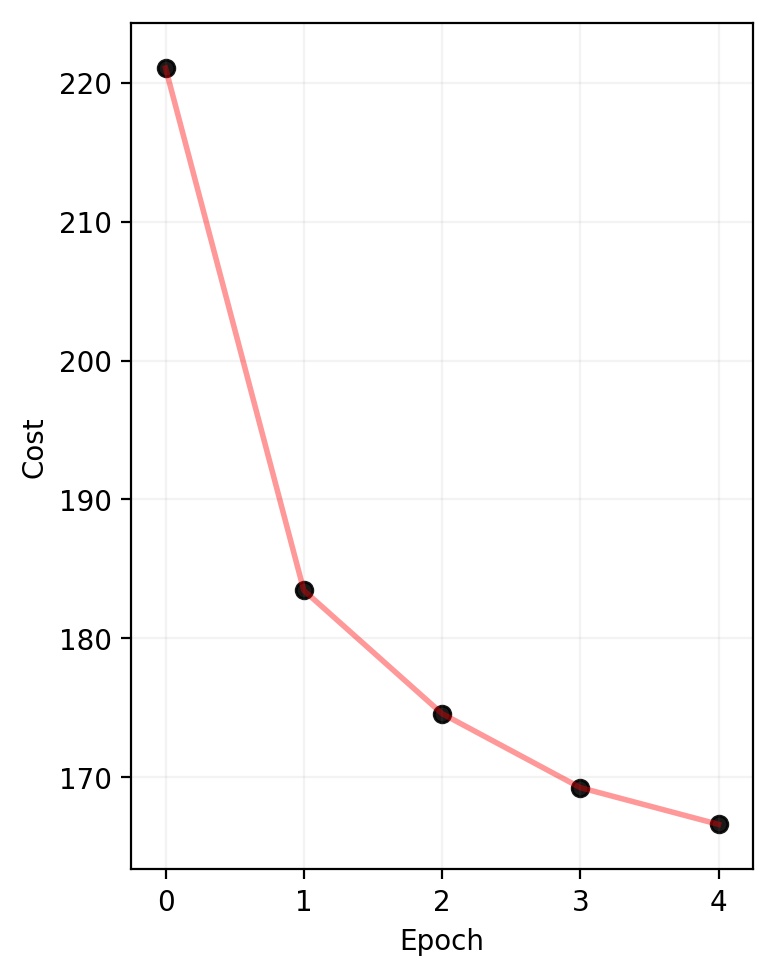

In [11]:
#train cost
visu.plotting_cost(cost_plotting)

In [15]:
#latens space visualization our training
visu.plotting_latent_space(laten_space, y_labels_m)

In [16]:
# reconstruction visualization
visu.plotting_training_visual(reconstructed, x_sample_m[:100])

Loading BokehJS ...

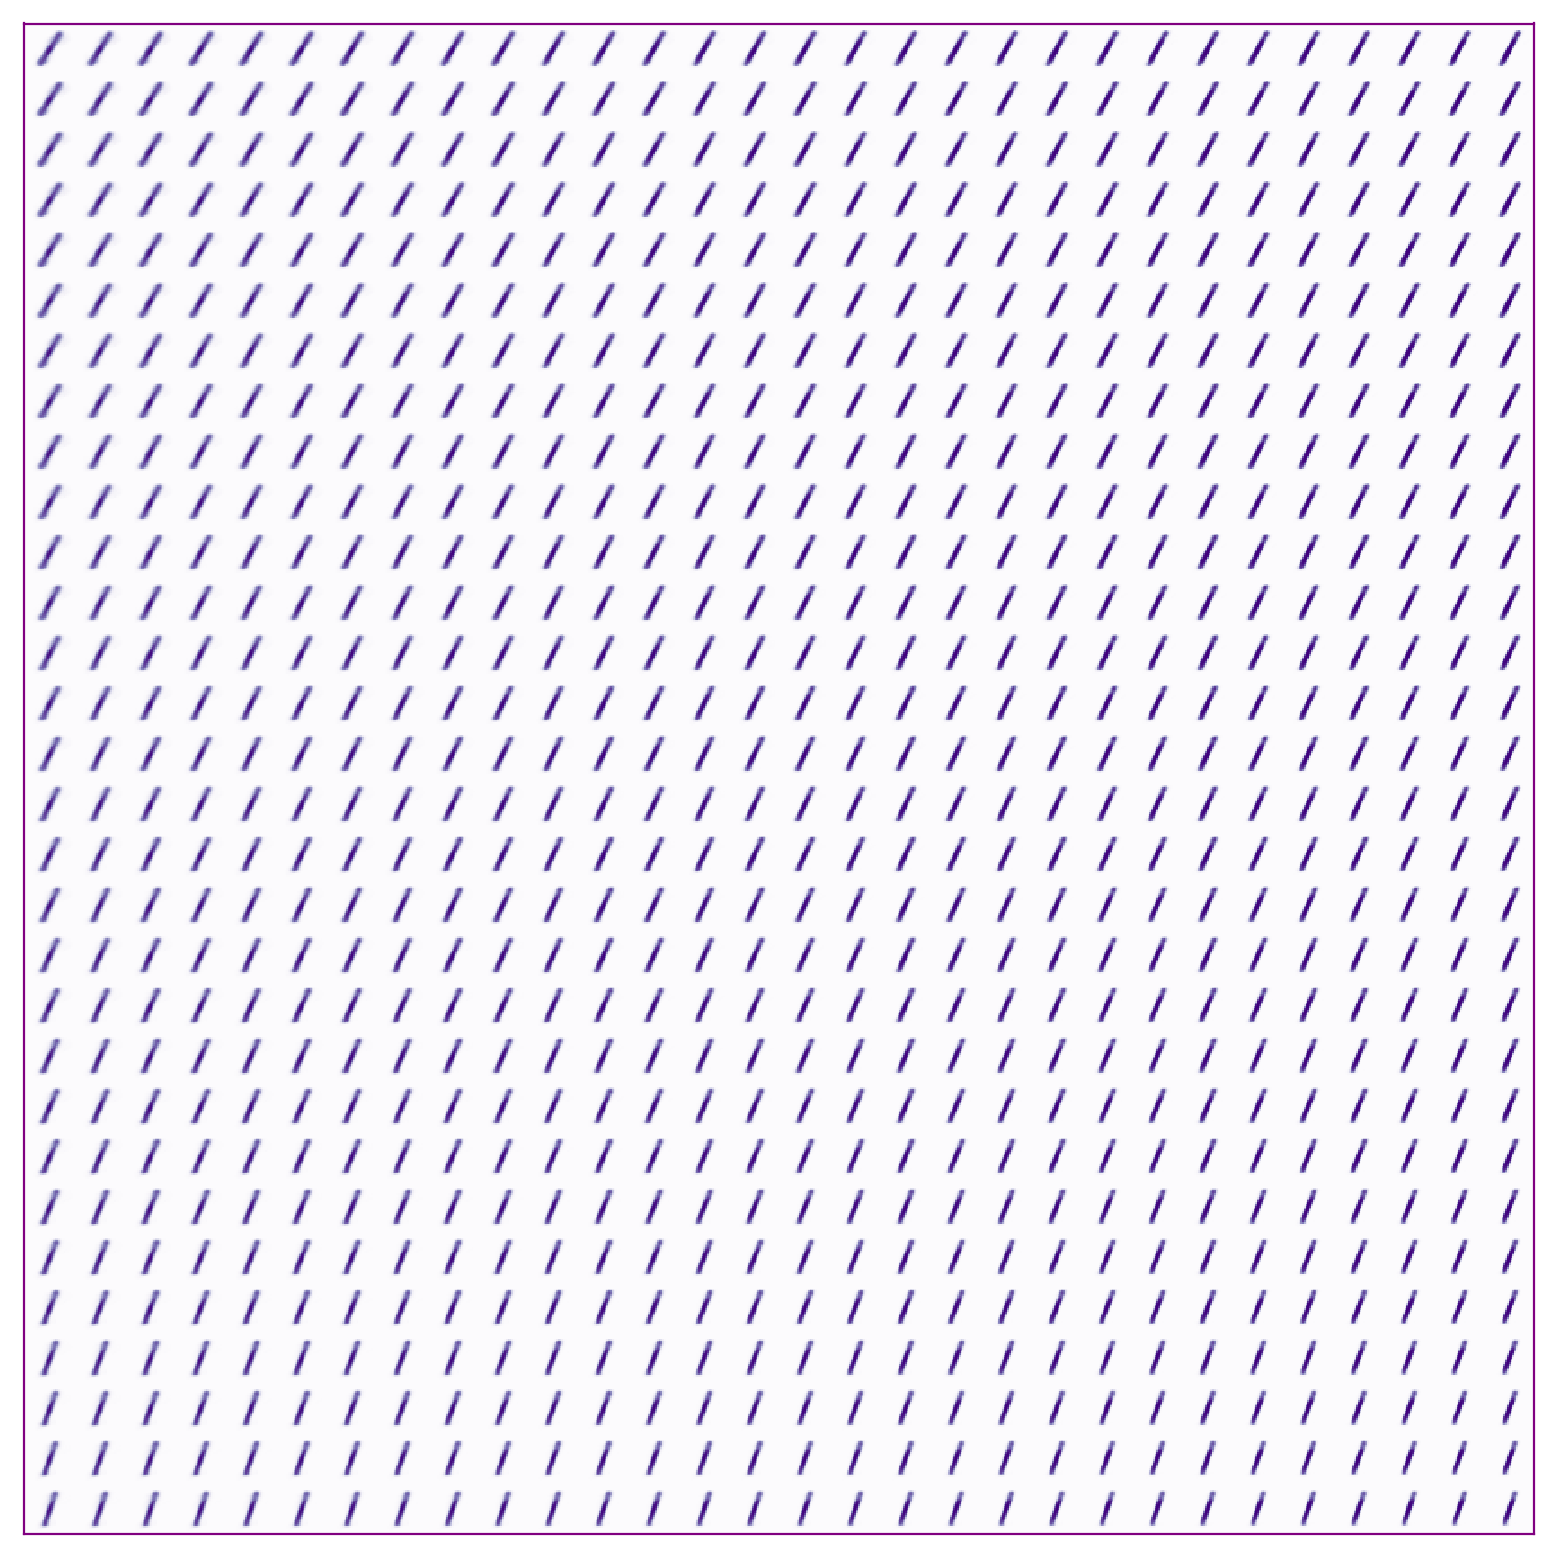

In [18]:
#generation of new data using custum mean
visu.plott_gener_sample_from_dist(0, 2, -4, -2)